In [35]:
import requests
import re
from datetime import datetime, timedelta
import os
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon

In [36]:
current_date = datetime.now().strftime('%Y%m%d')
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(1)]

In [37]:
base_url = "https://dd.weather.gc.ca/alerts/cap/"
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}

In [38]:
urls_cap = []

In [39]:
for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                # Extract filenames from the response using regular expressions
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                # Create complete URLs for .cap files and add them to the list
                for filename in filenames:
                    cap_url = url + filename
                    urls_cap.append(cap_url)
                    print(f"Added {cap_url} to the list.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")


Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WSCN13_C_CWVR_202308131103_0690310562.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN11_C_CWVR_202308131123_1437825484.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN11_C_CWVR_202308131123_1945971730.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN13_C_CWVR_202308131113_0496090114.cap to the list.


In [40]:
df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a dictionary for each set of coordinates
            for coord_pair in coords:
                lat, lon = map(float, coord_pair.split(','))
                data.append({'event': event, 'latitude': lat, 'longitude': lon})

        # Create a DataFrame from the extracted data
        polygon_df = pd.DataFrame(data)
        df.append(polygon_df)  # Append to the list of DataFrames

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(df, ignore_index=True)

# Display the first 6 rows of the concatenated DataFrame


In [41]:
final_df['identifer']='alert'

In [42]:
final_df.head(30)

,event,latitude,longitude,identifer
0,weather,50.4410,-121.4319,alert
1,weather,50.3298,-121.6568,alert
2,weather,50.3431,-121.9660,alert
3,weather,50.1832,-122.1663,alert
4,weather,50.3561,-122.5243,alert
5,weather,50.5465,-122.8931,alert
6,weather,50.7303,-123.2886,alert
7,weather,50.9894,-123.7789,alert
8,weather,50.9933,-123.7878,alert
9,weather,51.0000,-123.8000,alert


<Axes: xlabel='latitude', ylabel='longitude'>

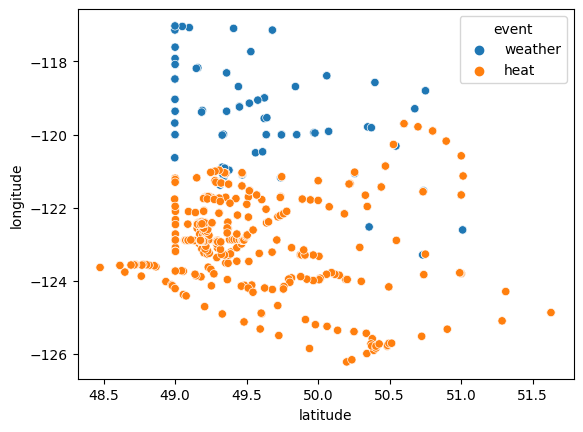

In [43]:
import seaborn as sns
sns.scatterplot(data=final_df,x='latitude',y='longitude',hue = 'event')

In [44]:
cities = pd.read_csv(r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv')
cities.sample(10)

,province,region,zipcode,latitude,longitude
448205,Ontario,York,L6C2R1,43.899870,-79.304109
91301,New Brunswick,Kings,E5S2A1,45.466398,-66.031180
548679,Ontario,Wellington,N1H3S9,43.533779,-80.270967
70904,New Brunswick,Madawaska,E3Y3K9,47.042335,-67.742005
386129,Ontario,Durham,L1J2T9,43.903143,-78.878558
448185,Ontario,York,L6C2M8,43.899695,-79.306399
248688,Quebec,Centre-du-Québec,J2B0N2,45.854807,-72.502819
871518,British Columbia,Capital,V8K2K7,48.850650,-123.501180
426631,Ontario,York,L4K0C8,43.810900,-79.508161
214078,Quebec,Montréal,H4M1H1,45.501830,-73.689410


In [45]:
cities['identifer']='city'
cities['event']='city'

In [46]:
cities.head(5)

,province,region,zipcode,latitude,longitude,identifer,event
0,Newfoundland & Labrador,Conception Bay - St. Johns,A0A0A0,47.582052,-53.279852,city,city
1,Newfoundland & Labrador,Conception Bay - St. Johns,A0A0A1,47.423351,-53.196602,city,city
2,Newfoundland & Labrador,Conception Bay - St. Johns,A0A0A2,47.385590,-53.134060,city,city
3,Newfoundland & Labrador,Conception Bay - St. Johns,A0A0A3,46.737209,-53.363831,city,city
4,Newfoundland & Labrador,Conception Bay - St. Johns,A0A0A4,47.536968,-53.269871,city,city


In [47]:
# Keep only desired columns
dt = cities[['latitude', 'longitude', 'identifer','event']]
dp = final_df[['latitude', 'longitude', 'identifer','event']]

# Concatenate dataframes
dg = pd.concat((dt, dp), axis=0)

In [48]:
dg

,latitude,longitude,identifer,event
0,47.582052,-53.279852,city,city
1,47.423351,-53.196602,city,city
2,47.385590,-53.134060,city,city
3,46.737209,-53.363831,city,city
4,47.536968,-53.269871,city,city
...,...,...,...,...
1119,50.999900,-121.650000,alert,heat
1120,51.013000,-121.131100,alert,heat
1121,51.000000,-120.580000,alert,heat
1122,50.894700,-120.177000,alert,heat


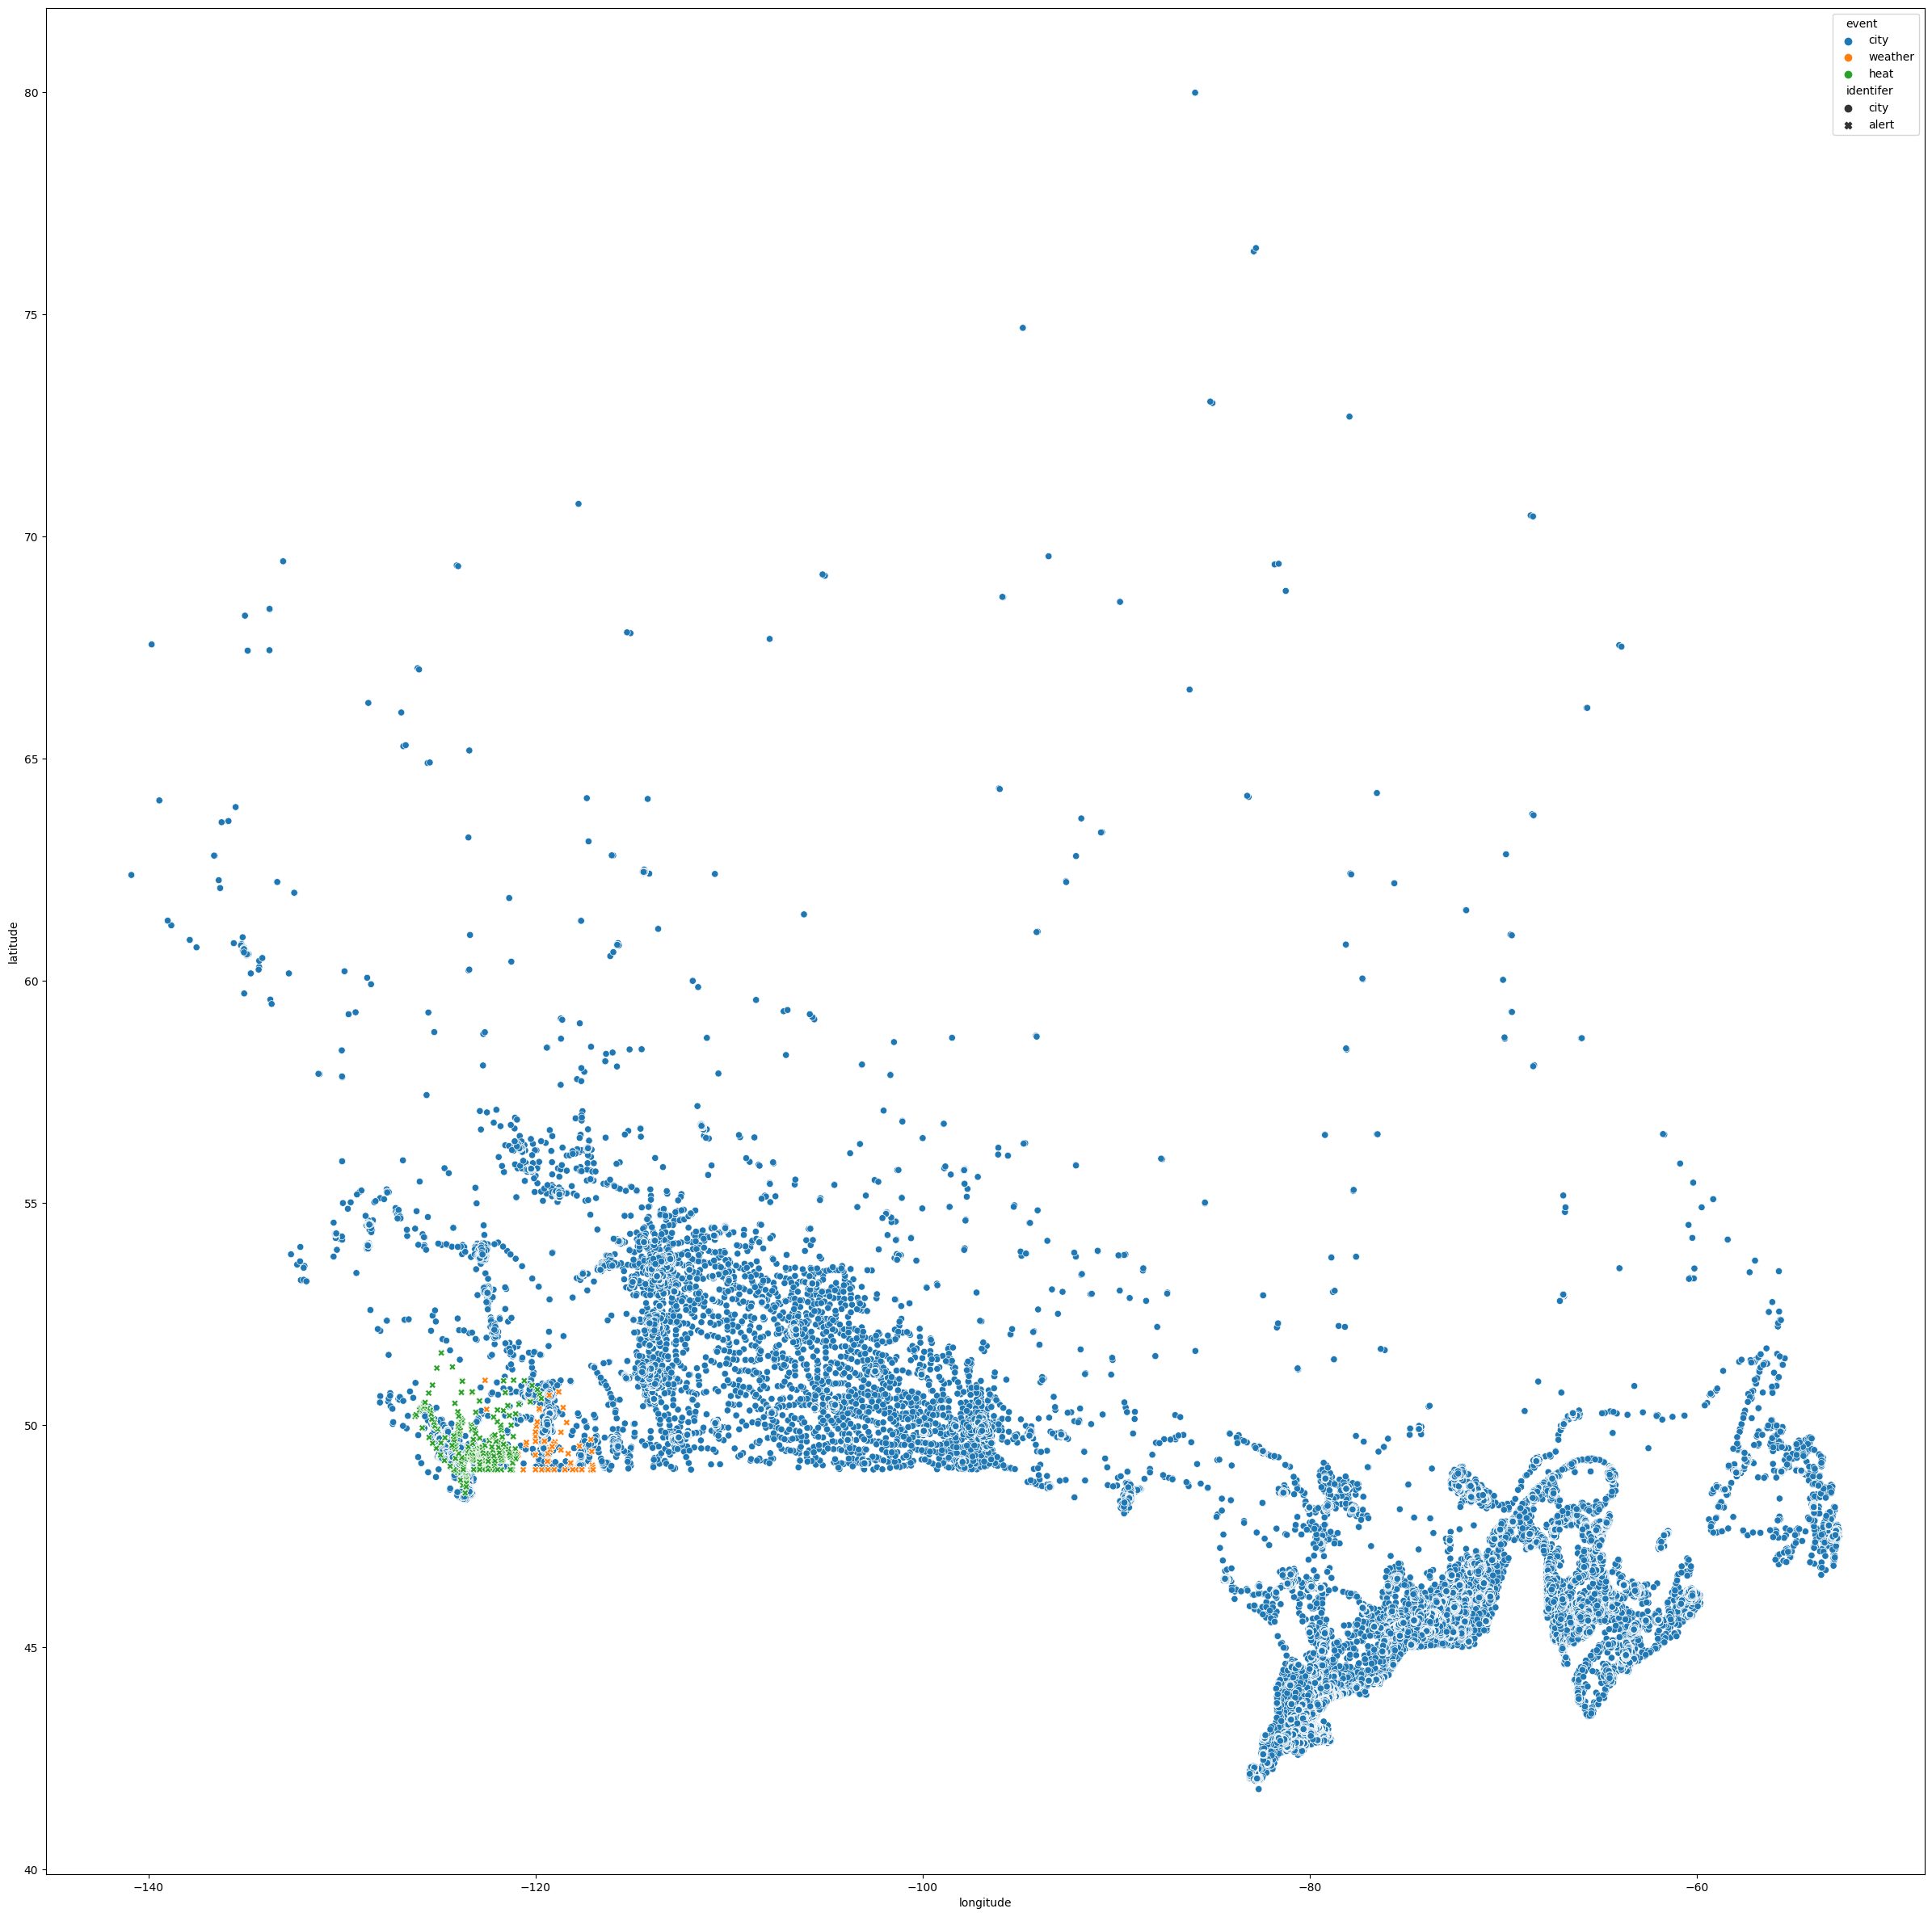

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = dg, x='longitude',y='latitude',style='identifer',hue='event')
plt.show()

In [50]:

# Define namespaces for CAP elements

df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a polygon string
            polygon_str = ",".join(coords)

            data.append({'event': event, 'polygon': polygon_str})

        # Append to the list of dictionaries
        df.append(data)

# Flatten the list of dictionaries and create a DataFrame
final_df = pd.DataFrame([item for sublist in df for item in sublist])

# Display the first 6 rows of the DataFrame
final_df.drop_duplicates()
final_df.head(5)

,event,polygon
0,weather,"50.441,-121.4319,50.3298,-121.6568,50.3431,-12..."
1,weather,"49.8499,-120.0012,49.5618,-120.4962,49.3465,-1..."
2,weather,"49.6368,-120.0011,49.3375,-119.9892,48.9994,-1..."
3,weather,"50.7499,-118.8,50.3966,-118.574,50.06,-118.389..."
4,weather,"49.6244,-118.9946,49.6228,-119.5566,49.6368,-1..."


ValueError: could not convert string to float: '.'

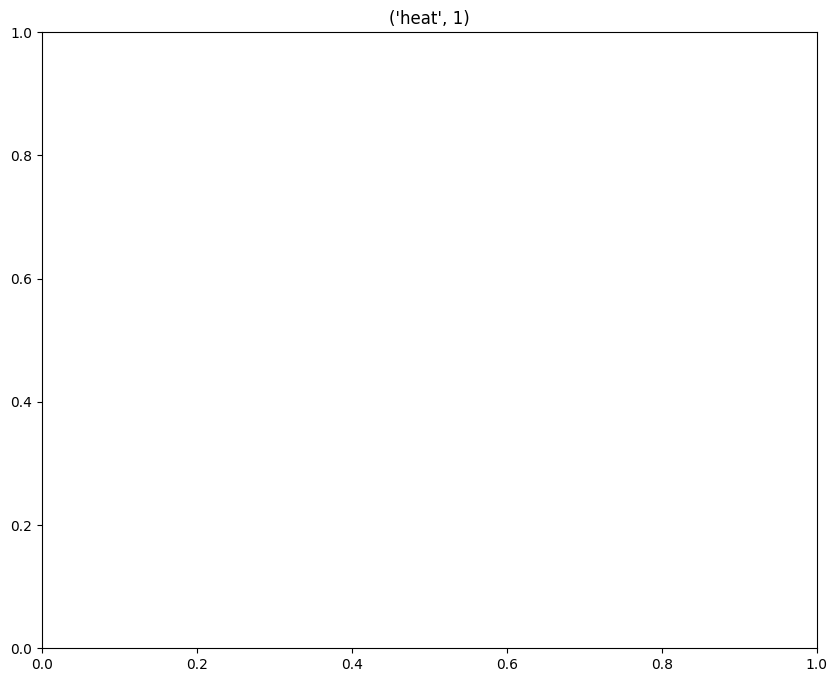

In [60]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import pandas as pd
import math

# Initialize a figure
plt.figure(figsize=(10, 8))

# Group points by event name
grouped_points = final_df.groupby('event')['polygon'].apply(lambda x: x.str.split(','))

# Plot polygons and grouped points for each event
for event, group in grouped_points.items():
    plt.title(event)
    for coords in group:
        coords = [(float(coord), float(lon_coord)) for coord, lon_coord in zip(coords[::2], coords[1::2])]  # Corrected index slicing
        centroid_x = sum(x for x, y in coords) / len(coords)
        centroid_y = sum(y for x, y in coords) / len(coords)
        sorted_coords = sorted(coords, key=lambda p: math.atan2(p[1] - centroid_y, p[0] - centroid_x))
        
        polygon = Polygon(sorted_coords)
        plt.plot(*polygon.exterior.xy, label=event, color='blue')
        plt.fill(*polygon.exterior.xy, alpha=0.2)  # Fill the polygon with a color
    
    # Combine all points for the event
    points_inside = []
    for point_coords in group:
        for coord in point_coords:
            points_inside.append(coord)
    points_inside = list(zip(*points_inside))
    plt.scatter(*points_inside, color='red', label='Points Inside', marker='o', s=50, alpha=0.7)

# Set plot labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygons of Events with Grouped Points Inside')
plt.legend()

# Show the plot
plt.show()


In [52]:
final_df.shape

(2, 2)

ValueError: could not convert string to float: '.'

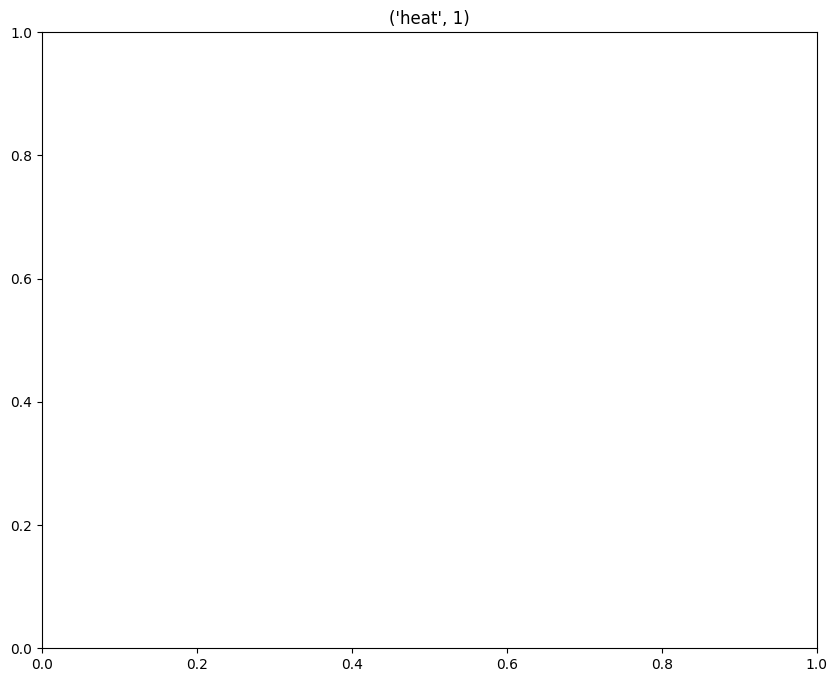

In [59]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import pandas as pd
import math



# Initialize a figure
plt.figure(figsize=(10, 8))

# Group points by event name
grouped_points = final_df.groupby('event')['polygon'].apply(lambda x: x.str.split(','))

# Plot polygons and grouped points for each event
for event, group in grouped_points.items():
    plt.title(event)
    for coords in group:
        coords = [(float(coord), float(lon_coord)) for coord, lon_coord in zip(coords[::2], coords[1::2])]  # Corrected index slicing
        centroid_x = sum(x for x, y in coords) / len(coords)
        centroid_y = sum(y for x, y in coords) / len(coords)
        sorted_coords = sorted(coords, key=lambda p: math.atan2(p[1] - centroid_y, p[0] - centroid_x))
        
        polygon = Polygon(sorted_coords)
        plt.plot(*polygon.exterior.xy, label=event, color='blue')
        plt.fill(*polygon.exterior.xy, alpha=0.2)  # Fill the polygon with a color
    
    # Combine all points for the event
    points_inside = []
    for point_coords in group:
        for coord in point_coords:
            points_inside.append(coord)
    points_inside = list(zip(*points_inside))
    plt.scatter(*points_inside, color='red', label='Points Inside', marker='o', s=50, alpha=0.7)

# Set plot labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygons of Events with Grouped Points Inside')
plt.legend()

# Show the plot
plt.show()


In [54]:
%%skip  # use the formula to make polygon
from shapely.geometry import Polygon, Point

# Define the vertices of the polygon as a list of (x, y) coordinates
polygon_vertices = [(0, 0), (0, 5), (5, 5), (5, 0)]

# Create a Shapely Polygon object
polygon = Polygon(polygon_vertices)

# Define a list of points to check
points_to_check = [(2, 3), (4, 4), (1, 1), (6, 2)]

# Check each point against the polygon
for point in points_to_check:
    point_object = Point(point[0], point[1])
    if polygon.contains(point_object):
        print(f"Point {point} is inside the polygon")
    else:
        print(f"Point {point} is outside the polygon")


UsageError: Cell magic `%%skip` not found.


In [55]:
# Create a list to store alert cities
alert_cities = []

# Iterate over each row in final_df
for _, row in final_df.iterrows():
    event = row['event']
    polygon_coords = [(float(coord), float(lon_coord)) for coord, lon_coord in zip(row['polygon'].split(','), row['polygon'].split(',')[1::2])]
    
    # Create a Shapely Polygon
    polygon = Polygon(polygon_coords)
    
    # Iterate over each city
    for index, city in cities.iterrows():
        city_point = Point(city['longitude'], city['latitude'])
        
        # Check if the city is inside the polygon
        if city_point.within(polygon):
            alert_cities.append({
                'province': city['province'],
                'region': city['region'],
                'alert': event
            })


KeyboardInterrupt: 

In [ ]:
alert = pd.DataFrame(alert_cities)
alert.head(30)

""


bottom codes are for simplifyication. The assignment ends above.

In [ ]:
%%skip
import requests
import re
from datetime import datetime, timedelta
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon

current_date = datetime.now().strftime('%Y%m%d')
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(1)]
base_url = "https://dd.weather.gc.ca/alerts/cap/"
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
urls_cap = []

for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                # Extract filenames from the response using regular expressions
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                # Create complete URLs for .cap files and add them to the list
                for filename in filenames:
                    cap_url = url + filename
                    urls_cap.append(cap_url)
                    print(f"Added {cap_url} to the list.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")

df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a polygon string
            polygon_str = ",".join(coords)

            data.append({'event': event, 'polygon': polygon_str})

        # Append to the list of dictionaries
        df.extend(data)

# Flatten the list of dictionaries and create a DataFrame
final_df = pd.DataFrame(df)

# Group final_df by 'event'
grouped = final_df.groupby(['event'])['polygon'].apply(','.join).reset_index()

# Merge grouped DataFrame with final_df based on 'event'
final_df = final_df.merge(grouped, on=['event'], how='left')

# Drop the duplicated 'polygon_x' column and rename 'polygon_y' to 'polygon'
final_df.drop(columns=['polygon_x'], inplace=True)
final_df.rename(columns={'polygon_y': 'polygon'}, inplace=True)

# Drop duplicate rows based on 'event'
final_df.drop_duplicates(subset=['event'], keep='first', inplace=True)

# Reset the DataFrame index
final_df.reset_index(drop=True, inplace=True)

# Load city data
cities = pd.read_csv(r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv')

# Create a list to store alert cities
alert_cities = []

# Iterate over each row in final_df
for _, row in final_df.iterrows():
    event = row['event']
    polygon_coords = [(float(coord), float(lon_coord)) for coord, lon_coord in zip(row['polygon'].split(','), row['polygon'].split(',')[1::2])]
    
    # Create a Shapely Polygon
    polygon = Polygon(polygon_coords)
    
    # Iterate over each city
    for index, city in cities.iterrows():
        city_point = Point(city['longitude'], city['latitude'])
        
        # Check if the city is inside the polygon
        if city_point.within(polygon):
            alert_cities.append({
                'province': city['province'],
                'region': city['region'],
                'alert': event
            })

# Create the alert DataFrame
alert = pd.DataFrame(alert_cities)

# Display the first 5 rows of the alert DataFrame
print(alert.head())


UsageError: Cell magic `%%skip` not found.


In [ ]:
%%skip
import requests
from datetime import datetime, timedelta
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon

# Getting current date and time
current_date = datetime.now().strftime('%Y%m%d')
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(1)]

# Base URL and responsible offices
base_url = "https://dd.weather.gc.ca/alerts/cap/"
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']

# Namespace for XML elements
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}

# Collect CAP URLs
urls_cap = []
for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                urls_cap.extend([url + filename for filename in filenames])
                print(f"Added {len(filenames)} CAP URLs from {office} for hour {hour}.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")

# Initialize a list to store CAP data
cap_data = []

# Iterate over each CAP file
for url in urls_cap:
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data
        for area in root.findall('.//cap:area', namespaces):
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()
            polygon_str = ",".join(coords)
            cap_data.append({'event': event, 'polygon': polygon_str})

# Create a DataFrame from the collected CAP data
final_df = pd.DataFrame(cap_data)

# Drop duplicates
final_df.drop_duplicates(inplace=True)

# Read city data
city_data_path = r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv'
cities = pd.read_csv(city_data_path)

# Initialize a list to store alert cities
alert_cities = []

# Iterate over each row in final_df
for _, row in final_df.iterrows():
    event = row['event']
    polygon_coords = [float(coord) for coord in row['polygon'].split(',')]
    polygon_points = [(polygon_coords[i], polygon_coords[i + 1]) for i in range(0, len(polygon_coords), 2)]
    polygon = Polygon(polygon_points)
    
    # Iterate over each city
    for _, city in cities.iterrows():
        city_point = Point(city['longitude'], city['latitude'])
        
        # Check if the city is inside the polygon
        if city_point.within(polygon):
            alert_cities.append({
                'province': city['province'],
                'region': city['region'],
                'alert': event
            })

# Create the alert DataFrame
alert_df = pd.DataFrame(alert_cities)

# Display the alert DataFrame
print(alert_df.head())

UsageError: Cell magic `%%skip` not found.
